In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from common.utils import load_sql_to_df, plot_history
from datasets import MoveAsTensorDataset
import board_representation as br

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from common.training import train_loop, test_model

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
classified_moves = load_sql_to_df("SELECT position, move, sentiment FROM classified_moves", "../../chess.db")
classified_moves

,position,move,sentiment
0,r2q1rk1/pp2bppp/2p1pnb1/4N1B1/2Q5/3P2N1/PPP2PP...,f6d5,0
1,8/2P2pkp/6p1/pP6/P3r1P1/6KP/4pP2/4R3 b - - 0 40,e4c4,1
2,8/8/8/8/5K2/6Q1/7k/8 b - - 14 63,h2h1,1
3,rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBN...,f1c4,1
4,r1q1r1k1/pp3pp1/2p2n2/2Nn3p/1PQN2b1/6P1/P2RPP1...,a7a6,1
...,...,...,...
272591,8/3b4/2p2kp1/pp2p2p/4P3/1P1P1NP1/P1P4P/6K1 w -...,d3d4,0
272592,r2qk2r/ppp2ppp/2np4/2b1p2b/4P3/2NP1N1P/PPP2PP1...,c3d5,0
272593,r5k1/7p/1qn5/p1p2QP1/P7/1N5P/1bP5/3R3K w - - 1 30,d1d7,1
272594,r4r1k/p5q1/bp2p1B1/2ppP3/6R1/2P3P1/PPQ2b1N/R6K...,f2e3,1


In [4]:
train_df, test_df = train_test_split(classified_moves, test_size=0.05)
display(train_df)
display(test_df)

,position,move,sentiment
112271,2b3k1/1pq3p1/3p3p/P1nPrp2/1R2P3/5P2/2Q3PP/R6K ...,h2h3,1
117364,rn3rk1/p4pp1/1pp1q1np/3pP2Q/3P4/2N2R1N/PPP3PP/...,c3e2,1
130427,r2q1rk1/1p2bppp/p1np1n2/4pPB1/8/P1NB4/1PP2PPP/...,a8c8,0
141258,rnbqkbnr/pppppppp/8/8/5P2/8/PPPPP1PP/RNBQKBNR ...,b8c6,1
248945,r2qkb1r/1p1b3p/4pp2/pPPp1n2/3n4/2P2N2/P2Q1PPP/...,c3d4,0
...,...,...,...
74299,2bqkb1r/2pp1ppp/2p2n2/r3p3/7P/2P1P3/P2P1PP1/RN...,h7h5,0
168009,rr4k1/p1bq1pp1/Q3p2p/3p4/3P2PP/P3PN2/1PPR4/2K4...,b8b6,1
182649,r2k3r/p2p1Bpp/2p2p2/2b1P3/1p2P3/2Pb4/PP4PP/R1B...,e5f6,0
25645,r1bq1rk1/3nppbp/2pp1np1/pp4N1/4P3/P1NP3P/BPP2P...,e7e6,0


,position,move,sentiment
72814,r1k1r3/ppp2ppp/5n2/4pb2/2P5/2B2PP1/PP3PBP/3RR1...,e5e4,0
155710,k1n1rb2/p2q4/N1p1rp2/1p1p1ppb/3P3p/PBN1PP1P/1P...,c8b6,1
63353,r2q1rk1/ppn1p1bp/2p1bpp1/3n4/2BP3B/1QN1PN2/PP3...,b7b5,1
4666,rnbqkbnr/ppp1pppp/3p4/8/8/2NP4/PPP1PPPP/R1BQKB...,b8c6,1
197615,N1bk3r/pp1p2pp/4nn2/6p1/1b6/3BP3/PqPN1PPP/2RQK...,b2c3,1
...,...,...,...
190874,rnbqk1nr/pppp1ppp/8/8/2B1Pp1b/5N2/PPPP2PP/RNBQ...,e1f1,0
72531,3r3r/1k2bppb/1pn1p2n/3pP3/3P1P1p/1NP1BN1P/4B1P...,h6f5,1
23096,3r1rk1/ppp1np1p/5bp1/5P2/3P4/2PB1q1R/P4P1P/2B3...,h3f3,1
45298,3r1rk1/pp2b1pp/4p1b1/P2nq3/Q3Np2/2P2B2/1P3PPP/...,b7b5,1


In [5]:
train_dataset = MoveAsTensorDataset(train_df)
test_dataset = MoveAsTensorDataset(test_df)

In [9]:
class SentimateNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(26, 26, 5, padding='same'),
            nn.Conv2d(26, 26, 3, padding='same'),
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(8*8*26, 500),
            nn.ELU(),
            nn.Linear(500, 200),
            nn.ELU(),
            nn.Linear(200, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 8*8*26)
        x = self.fc_layers(x)
        return x

In [7]:
model = SentimateNet()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
model

SentimateNet(
  (conv_layers): Sequential(
    (0): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=1664, out_features=500, bias=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=500, out_features=200, bias=True)
    (4): ELU(alpha=1.0)
    (5): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [39]:
train_loader = DataLoader(train_dataset, batch_size=2048)
test_loader = DataLoader(test_dataset, batch_size=2048)

In [40]:
test_model(train_loader, model)
test_model(test_loader, model)

Test Error: Accuracy: 56.21%, Avg loss: 0.688172
Test Error: Accuracy: 56.13%, Avg loss: 0.688299


In [41]:
history = train_loop(train_loader, model, test_dataloader=test_loader, num_epochs=100, optimizer=optimizer, verbose=True)

Epoch 1/250
Train loss: 0.685980, accuracy: 56.15%
Test loss:  0.684547, accuracy: 56.14%
-----------------------------
Epoch 2/250
Train loss: 0.684566, accuracy: 56.21%
Test loss:  0.684086, accuracy: 56.16%
-----------------------------
Epoch 3/250
Train loss: 0.683754, accuracy: 56.31%
Test loss:  0.683423, accuracy: 56.10%
-----------------------------
Epoch 4/250
Train loss: 0.682859, accuracy: 56.43%
Test loss:  0.683079, accuracy: 55.99%
-----------------------------
Epoch 5/250
Train loss: 0.682057, accuracy: 56.52%
Test loss:  0.683246, accuracy: 56.10%
-----------------------------
Epoch 6/250
Train loss: 0.681435, accuracy: 56.70%
Test loss:  0.683699, accuracy: 56.28%
-----------------------------
Epoch 7/250
Train loss: 0.680919, accuracy: 56.73%
Test loss:  0.682596, accuracy: 56.36%
-----------------------------
Epoch 8/250
Train loss: 0.680486, accuracy: 56.81%
Test loss:  0.681994, accuracy: 56.55%
-----------------------------
Epoch 9/250
Train loss: 0.679987, accura

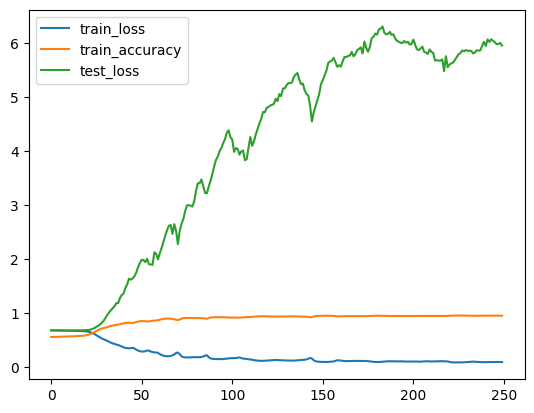

In [50]:
plot_history(history)

In [42]:
torch.save(model.state_dict, "../../models/Sentimate.model")